In [ ]:
# Folders project structure

# dataset |----> edfu       |----> epilesy #edf files
#                           |----> no_epilesy #edf files
#
#         |----> extraction |----> epilesy #edf to csv
#                           |----> no_epilesy #edf to csv
#
#         |----> division   |----> epilesy #csv standardize
#                           |----> no_epilesy #csv standardize
#
#         |----> info
#        
#         |----> prod


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.25.244.130:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.25.244.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.244.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
!pip install mne
!pip install -q pyyaml h5py 
!pip install -U keras-tuner

     |████████████████████████████████| 6.9MB 4.5MB/s 


In [4]:
projet_path = "/content/drive/MyDrive/dataset/"

In [5]:
cd {projet_path}

/content/drive/MyDrive/dataset


In [6]:
import mne
import os.path as path
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow.keras.layers.experimental import preprocessing
import scipy
from scipy.signal import filtfilt,butter
import pandas as pd
import seaborn as sns
import uuid
import shutil
pd.set_option('display.max_colwidth', None)

In [7]:
%load_ext tensorboard
!rm -rf {projet_path+"tensorboard_logs"}

#Functions

In [9]:
def get_label(file_path):
  return tf.strings.split(file_path,os.path.sep)[-2]

def get_sizes(csv_names):
  data = pd.DataFrame([],columns=["length","width","columns"])
  for file_path in csv_names:
    raw = pd.read_csv(file_path)
    data = data.append({"length":raw.shape[0],"width":raw.shape[1],"columns":list(raw.columns)}, ignore_index=True)
    
  return data

def make_df_info(csv_names):
  size = get_sizes(csv_names)
  data_shape = pd.DataFrame({"path":csv_names})
  data_shape = pd.concat([size,data_shape],axis=1)
  data_shape["label"] = data_shape.path.map(lambda x : x.split("/")[-2])
  return data_shape

In [ ]:
def csv_path_to_edf(path):
  return path.replace("extraction","edfu").replace("csv","edf")

def plot_raw(path,file_type="csv"):
  if file_type=="csv":
    path = csv_path_to_edf(path)

  raw = mne.io.read_raw_edf(path) 
  raw.plot()
    

In [ ]:
def str_index_to_list(index):
  return index.replace("'","").replace("[","").replace("]","").split(",")

def replace_diff(x):
  return x.replace("-REF","").replace("-LE","").replace("EEG","").replace(" ","")

In [ ]:
def divide_csv(df,threshold,p,column_names,continue_at=0):
  div=pd.DataFrame([],columns=column_names)

  for j, path in enumerate(df["path"]):
    if j >= continue_at:
      temp = pd.read_csv(path)

      temp.columns = replace_diff(",".join(list(temp.columns))).split(",")
      current_col = temp.columns
      to_drop = [ col for col in current_col if not col in column_names]
    
      temp.drop(to_drop,axis=1,inplace=True)
      current_col = temp.columns
      #print("1=>",div.shape)
      
      div = pd.concat([div,temp])
      current_col = div.columns
        
      if len(current_col)!=len(column_names):
        print("anomalie : "+str(len(current_col))+" colonnes")
        print(path)
        return

      nb_div = div.shape[0]//threshold
      label = path.split(os.path.sep)[-2]
      file_name = path.split(os.path.sep)[-1][:-4] 
      for i in range(1,nb_div+1):
        new_path = p+os.path.sep+label+os.path.sep+file_name+"_"+str(i)+".csv"
        if not os.path.isfile(new_path):
          div[:threshold].to_csv(new_path,index=False)
        div=div[(threshold):]
        #print(div.shape)
      print(str(j))
      if j+1==len(df["path"]) and div.shape[0]<threshold and not div.empty:
        rest = threshold - div.shape[0]
        dd = pd.DataFrame(np.zeros((rest,len(column_names))),columns=column_names)
        div = pd.concat([div,dd])
        new_path = p+os.path.sep+label+os.path.sep+str(uuid.uuid1())+".csv"
        if div.shape[0]!=threshold:
          print("anomalie : "+str(div.shape[0])+" lignes")
          print(path)
          return
        div.to_csv(new_path,index=False)
        print("reste",div.shape)
          

In [ ]:
def merge_csv(df,threshold,p,column_names):
  to_save = pd.DataFrame([],columns=column_names)
  end = False
  
  for i, path in enumerate(df["path"]):
    label = path.split(os.path.sep)[-2]
    if to_save.shape[0] < threshold:
      temp = pd.read_csv(path)
      temp.columns = replace_diff(",".join(list(temp.columns))).split(",")
      current_col = temp.columns
      to_drop = [ col for col in current_col if not col in column_names]
      temp.drop(to_drop,axis=1,inplace=True)
      current_col = temp.columns

      to_save = pd.concat([to_save,temp])

      if len(current_col)!=len(column_names):
        print("anomalie colonnes : "+str(len(current_col))+" colonnes")
        print(path)
        return

      if to_save.shape[0]>=threshold:
        new_path = p+os.path.sep+label+os.path.sep+"_i"+str(uuid.uuid1())+".csv"
        if to_save.shape[0]<threshold:
            print("anomalie lignes t1 : "+str(to_save.shape[0])+" lignes")
            print(path)
            return
        to_save[:threshold].to_csv(new_path)
        to_save = to_save[threshold:]
        
    print(str(i))
    
    if (len(df["path"])==i+1 and to_save.shape[0] < threshold):
      rest = threshold - to_save.shape[0]
      dd = pd.DataFrame(np.zeros((rest,len(column_names))),columns=column_names)
      to_save = pd.concat([to_save,dd])
      new_path = p+os.path.sep+label+os.path.sep+"_i"+str(uuid.uuid1())+".csv"
      if to_save.shape[0]!=threshold:
          print("anomalie lignes t2: "+str(to_save.shape[0])+" lignes")
          print(path)
          return
      print("fin : "+ str(to_save.shape[0]))
      to_save.to_csv(new_path)
      return

In [ ]:
def passBandFilter(signal):
  fs = 40000.0
  lowcut = 0.1
  highcut = 50.0
  nyq = fs * 0.5
  low = lowcut  / nyq
  high = highcut  / nyq

  b, a = butter(2,[low,high],"bandpass",analog=False)
  y=filtfilt(b,a,signal,axis=0)
  return y

def plot_signal_spect(data_column,col_name):
  filteredSig=passBandFilter(data_column)
  spect = tf.signal.stft(data_column, frame_length=255, frame_step=128)
  #spect = lib.feature.mfcc(np.array(filteredSig),n_mfcc=20)
  spect = tf.abs(tf.dtypes.cast(spect, tf.float64))
  length = len(data_column)

  plt.figure(figsize=(12,8))
  timescale = np.arange(length) 

  plt.subplot(3,1,1,xlim=[0, length],title="Waveform - "+col_name,xticklabels=[] )
  plt.plot(timescale,data_column)

  plt.subplot(3,1,2,xlim=[0, length],title="Waveform filtered - "+col_name,xticklabels=[] )
  plt.plot(timescale,filteredSig)

  plt.subplot(3,1,3,title="Spectrogram - "+col_name )
  #lib_disp.specshow(lib.amplitude_to_db(spect.numpy()))
  lib_disp.specshow(lib.amplitude_to_db(spect.numpy().T))
  plt.show()

def plot_signals_spects(data_frame,plot_all=False):
  for col in data_frame.columns:
    plot_signal_spect(list(data_frame[col]),col)
    if not plot_all:
      break

In [ ]:
def get_data_label2(file_names):
  scaler = MinMaxScaler()
  encoder = LabelEncoder()
  data = []
  labels = []
  for i,path in enumerate(file_names):
    label = tf.compat.as_str(
      get_label(path).numpy(), encoding='utf-8')
    raw = pd.read_csv(path)
    nd=[]
    print(i)
    if 'Unnamed: 0' in list(raw.columns):
      raw.drop("Unnamed: 0",axis=1,inplace=True,errors="ignore")
      raw.to_csv(path,index=False)

    for col in raw.columns:
      
      #filteredSig=passBandFilter(raw[col])
      #spect = lib.feature.mfcc(np.array(filteredSig),n_mfcc=20)
      spect = tf.signal.stft(list(raw[col]), frame_length=255, frame_step=128,)
      spect = tf.abs(tf.dtypes.cast(spect, tf.float64))
      nd.append(lib.amplitude_to_db(spect.numpy()))
      
    nd=np.transpose(nd, (1, 2, 0))
    raw = tf.convert_to_tensor(nd/nd.max())
    data.append(raw)
    labels.append(label)
  labels=encoder.fit_transform(labels)  
  print(labels)

  return (data,labels)

def divide_file(data_file,threshold,p,nb_cols=19):
  cols = [str(i) for i in range((nb_cols))]
  div=pd.DataFrame([],columns=cols)

  for j, path in enumerate(data_file["path"]):
    temp = pd.read_csv(path)
      
    n_cols = len((temp.columns))
    if n_cols > nb_cols:
      to_drop = temp.columns[nb_cols:]
      temp.drop(to_drop,axis=1,inplace=True)
      
    else :
      rest = nb_cols - n_cols
      rembourrage = np.zeros((threshold,1))
      for i in range(rest):
        temp[i]=rembourrage
        
    if len(temp.columns)!=nb_cols:
      print("anomalie : "+str(temp.columns)+" colonnes")
      print(path)
      return
    temp.columns = cols#div.columns
    div = pd.concat([div,temp])

    if div.shape[0]>threshold:
      nb_div = div.shape[0]//threshold
      file_name = path.split(os.path.sep)[-1][:-4] 
      for i in range(1,nb_div+1):
        new_path = p+file_name+"_"+str(i)+".csv"
        if not os.path.isfile(new_path):
          div[:threshold].to_csv(new_path,index=False)
        div=div[(threshold):]
        #print(div.shape)
      print(str(j))
      if j+1==len(data_file["path"]) and div.shape[0]<threshold and not div.empty:
        rest = threshold - div.shape[0]
        dd = pd.DataFrame(np.zeros((rest,len(div.columns))),columns=div.columns)
        div = pd.concat([div,dd])
        new_path = p+str(uuid.uuid1())+".csv"
        if div.shape[0]!=threshold:
          print("anomalie : "+str(div.shape[0])+" lignes")
          print(path)
          return
        div.to_csv(new_path,index=False)
        print("reste",div.shape)

def preprocessing(root,edf_files=[],id=str(uuid.uuid1())):
  data_file = pd.DataFrame([],columns=["length","width","path","columns"])

  dir = root+"prod"+os.path.sep+id+os.path.sep
  tf.io.gfile.makedirs(dir)
  for path in edf_files:
    file_name = path.split(os.path.sep)[-1][:-4]
    new_path = dir+os.path.sep+file_name+".csv"
    
    if not os.path.isfile(new_path):
      raw = mne.io.read_raw_edf(path)
      df = pd.DataFrame(raw.to_data_frame(),columns=raw.ch_names)
      data_file = data_file.append({"length":df.shape[0],"width":df.shape[1],"path":new_path,"columns":list(df.columns)}, ignore_index=True)
      df.to_csv(new_path,index=False)
  
  #suppresion des edf

  threshold=40000
  # division
  divide_file(data_file,threshold,dir)

  #suppression des csv
  for path in data_file["path"]:
    os.remove(path)

  print(dir[:-1])
  csv_names = tf.io.gfile.glob(str(dir) + '*.csv')

  return csv_names
  

def prediction(data_set):
  modele = models.load_model(projet_path+'my_model.h5')
  preds = modele.predict_classes(data_set)
  score = {"epilepsy": 0,"no_epilepsy": 0}
  for pred in preds:
    if pred == 0:
      score["epilepsy"]+=1
    else:
      score["no_epilepsy"]+=1
  print("predictions :" preds)
  print("score :" score)
  return  max(score, key=lambda k: score[k])

#Loading


In [10]:
# edf folder and sub folders
dir_data_set = path.join(projet_path,"edfu") 
dir_epilepsy = path.join(dir_data_set,"epilepsy")
dir_no_epilepsy = path.join(dir_data_set,"no_epilepsy")

In [11]:
extraction_path = "/content/drive/MyDrive/dataset/extraction"
file_info_path = "/content/drive/MyDrive/dataset/info/size.csv"
division_path = "/content/drive/MyDrive/dataset/division"
log_dir = "/content/drive/MyDrive/dataset/tensorboard_logs/"

In [12]:
#get all edf files
edf_names = tf.io.gfile.glob(str(dir_data_set) + '/*/*.edf')

Extracting EDF parameters from /content/drive/MyDrive/dataset/edfu/epilepsy/00007645_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


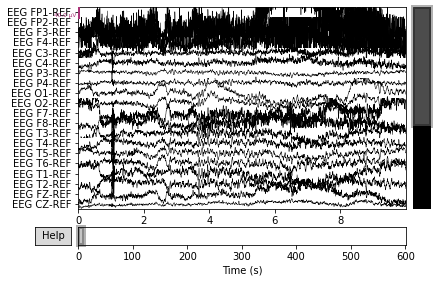

In [ ]:
plot_raw(path.join(dir_epilepsy,os.listdir(dir_epilepsy)[0]))

Extracting EDF parameters from /content/drive/MyDrive/dataset/edfu/no_epilepsy/00002744_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


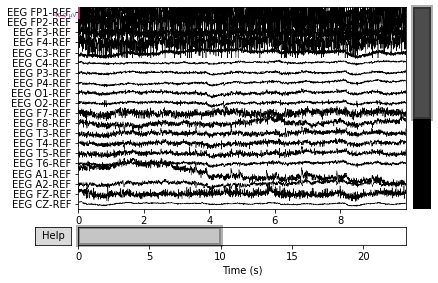

In [ ]:
plot_raw(path.join(dir_no_epilepsy,os.listdir(dir_no_epilepsy)[0]))

In [ ]:
#random dataset columns 
columns=['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
       'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
       'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
       'EEG T6-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG FZ-REF', 'EEG CZ-REF',
       'EEG PZ-REF', 'EEG ROC-REF', 'EEG LOC-REF', 'EEG EKG1-REF', 'EMG-REF',
       'EEG 26-REF', 'EEG 27-REF', 'EEG 28-REF', 'EEG 29-REF', 'EEG 30-REF',
       'EEG T1-REF', 'EEG T2-REF', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR']

In [ ]:
num_samples = len(edf_names)
labels = tf.io.gfile.listdir(str(dir_data_set))
num_epil = len(tf.io.gfile.listdir(str(dir_data_set + "/" + labels[1])))
num_no_epil = len(tf.io.gfile.listdir(str(dir_data_set + "/" + labels[0])))
print(f"total of sample {num_samples}")
print(f"total of epilepsy {num_epil}")
print(f"total of no_epilepsy {num_no_epil}") 

total of sample 1656
total of epilepsy 1368
total of no_epilepsy 288


#Transformation edf into csv

In [ ]:
#data = pd.DataFrame([],columns=["length","width","label","path","columns"])
for path in edf_names:
  label = path.split(os.path.sep)[-2]
  file_name = path.split(os.path.sep)[-1][:-4]
  new_path = extraction_path+os.path.sep+label+os.path.sep+file_name+".csv"
  
  if not os.path.isfile(new_path):
    raw = mne.io.read_raw_edf(path)
    df = pd.DataFrame(raw.to_data_frame(),columns=raw.ch_names)
    #data = data.append({"length":df.shape[0],"width":df.shape[1],"label":label,"path":new_path,"columns":list(df.columns)}, ignore_index=True)
    df.to_csv(new_path,index=False)

#data.to_csv(file_info_path,index=False)

In [ ]:
csv_names = tf.io.gfile.glob(str(extraction_path) + '/*/*.csv')

# Extraction des informations

In [ ]:
# get some informations about csv generated
if not os.path.isfile(file_info_path):
  data_shape = make_df_info(csv_names)
  data_shape.to_csv(file_info_path,index=False)
 

In [ ]:
'''
temp = make_df_info(csv_names[1200:])
data_shape = pd.concat([data_shape,temp])
data_shape.to_csv(file_info_path,index=False)'''

'\ntemp = make_df_info(csv_names[1200:])\ndata_shape = pd.concat([data_shape,temp])\ndata_shape.to_csv(file_info_path,index=False)'

# Informations about csv files

In [ ]:
data_shape = pd.read_csv(file_info_path)

In [ ]:
data_shape.describe()

,length,width
count,1.656000e+03,1656.000000
mean,2.492311e+05,33.140700
std,6.131227e+05,3.570119
min,1.250000e+03,27.000000
25%,7.680000e+04,30.000000
50%,1.538560e+05,34.000000
75%,3.035625e+05,36.000000
max,1.783760e+07,41.000000


In [ ]:
# separate csv files according a threshold for standardize the dataset
threshold2=40000

df3=data_shape[(data_shape["length"]>threshold2) & (data_shape["label"]=="epilepsy")]
df4=data_shape[(data_shape["length"]>threshold2) & (data_shape["label"]=="no_epilepsy")]

df5=data_shape[(data_shape["length"]<threshold2) & (data_shape["label"]=="epilepsy")]
df6=data_shape[(data_shape["length"]<threshold2) & (data_shape["label"]=="no_epilepsy")]


In [ ]:
print(f"{len(df3)} Fichiers de label epilepsy avec un nb d'enregistrement > {threshold2} ")
print(f"{len(df4)} Fichiers de label no_epilepsy avec un nb d'enregistrement > {threshold2} ")
print(f"{len(df5)} Fichiers de label epilepsy avec un nb d'enregistrement < {threshold2} ")
print(f"{len(df6)} Fichiers de label no_epilepsy avec un nb d'enregistrement < {threshold2} ")


1263 Fichiers de label epilepsy avec un nb d'enregistrement > 40000 
186 Fichiers de label no_epilepsy avec un nb d'enregistrement > 40000 
105 Fichiers de label epilepsy avec un nb d'enregistrement < 40000 
101 Fichiers de label no_epilepsy avec un nb d'enregistrement < 40000 


In [ ]:
# Differents type of column
data_shape["columns"] = data_shape["columns"].apply(replace_diff)
cols = data_shape["columns"].value_counts()
cols

['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','T1','T2','FZ','CZ','PZ','EKG1','C3P','C4P','SP1','SP2','EMG','A1','A2','31','32','IBI','BURSTS','SUPPR']                                                                 405
['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','A1','A2','FZ','CZ','PZ','ROC','LOC','EKG1','EMG','26','27','28','29','30','T1','T2','PHOTIC','IBI','BURSTS','SUPPR']                                                     305
['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','A1','A2','FZ','CZ','PZ','ROC','LOC','EKG1','T1','T2','PHOTIC','IBI','BURSTS','SUPPR']                                                                                    169
['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','T1','T2','FZ','CZ','PZ','EKG1','A1','A2','IBI','BURSTS','SUPPR']                                                                                 

# Fixing dimensions issue

In [ ]:
# extract columns that don't appear in the whole dataset
to_del = []
for i,col1 in enumerate(cols.index):
  col1 = str_index_to_list(col1)
  for j,col2 in enumerate(cols.index):
    if i!=j:
      col2 = str_index_to_list(col2)
      to_del = np.append(to_del,(list(set(col1)-set(col2)) + list(set(col2)-set(col1))))
to_del = np.unique(to_del)

In [ ]:
# get standardized column names for the dataset
cols = replace_diff(",".join(columns)).split(",")
columns = [col for col in cols if not col in to_del]
print(columns)
print(f"nb de colonnes {len(columns)} ")

['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
nb de colonnes 19 


## Standardization

In [ ]:
#merge_csv(df5,threshold2,division_path,columns)

In [ ]:
#merge_csv(df6,threshold2,division_path,columns)

In [ ]:
#divide_csv(df3,threshold2,division_path,columns) 

In [ ]:
#divide_csv(df4,threshold2,division_path,columns)

#Preprocessing

In [19]:
divided_names = tf.io.gfile.glob(str(division_path) + '/*/*.csv')

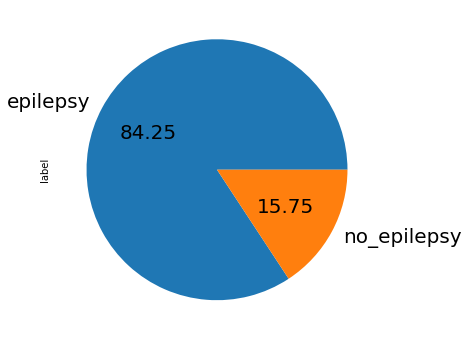

In [20]:
names_label=pd.DataFrame(divided_names,columns=["path"])
names_label["label"]=names_label.path.map(lambda x : x.split("/")[-2])
names_label.label.value_counts().plot.pie(autopct="%.2f",fontsize=20, figsize=(6, 6),)

In [21]:
# show a random sample standard dataframe
random_nb = np.random.randint(0,len(divided_names))
print(random_nb)
df=pd.read_csv(divided_names[random_nb])
df

5636


,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
0,-4.680712,-0.330622,-21.077203,-4.848023,-10.369290,-7.525001,-13.882824,-18.734847,-13.548202,-9.365424,-8.361557,5.692579,-15.221313,-2.003734,-15.890558,-8.863490,-12.711646,-19.236781,-12.209713
1,-7.190379,-5.349956,-22.081070,-5.684579,-11.875091,-8.863490,-13.380891,-20.909892,-14.719380,-10.871224,-11.038535,3.015600,-16.559802,-4.178778,-17.229047,-11.875091,-13.213580,-19.404092,-10.703913
2,-5.517267,-2.505667,-21.411825,-3.676845,-9.867357,-8.194246,-15.221313,-20.407959,-15.388625,-10.871224,-10.369290,5.190645,-17.061736,-3.174912,-16.392491,-11.373157,-11.540468,-19.236781,-13.882824
3,-2.505667,4.521401,-20.909892,-2.505667,-8.863490,-7.357690,-17.061736,-19.404092,-15.890558,-10.703913,-10.536602,6.863757,-17.396358,-1.669111,-16.392491,-10.201979,-10.703913,-19.236781,-16.894425
4,-4.011467,3.684845,-22.248381,-3.342223,-10.703913,-8.194246,-15.890558,-20.742581,-16.727114,-11.205846,-11.707780,5.692579,-18.567536,-3.676845,-18.902158,-11.707780,-11.707780,-19.236781,-15.388625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-23.084937,-21.077203,-27.100404,-17.898292,-9.867357,-15.890558,-12.544335,-13.882824,-9.365424,-5.015334,-13.380891,-27.100404,-10.703913,-26.263848,-13.715513,-17.898292,-20.742581,-21.244514,-0.497933
39996,-19.571403,-14.719380,-25.092670,-16.894425,-7.190379,-15.054002,-14.050135,-12.042402,-9.532735,-4.011467,-10.871224,-24.256115,-9.198112,-24.256115,-12.042402,-15.388625,-18.902158,-21.579137,-4.178778
39997,-20.073336,-15.221313,-24.925359,-17.563669,-8.026935,-15.723247,-13.380891,-12.711646,-9.532735,-4.178778,-11.373157,-24.590737,-10.369290,-24.423426,-12.209713,-15.723247,-19.404092,-21.746448,-3.509534
39998,-20.575270,-17.396358,-25.092670,-18.734847,-10.201979,-17.229047,-11.205846,-14.552069,-9.030801,-4.178778,-11.373157,-26.096537,-10.536602,-25.427293,-13.380891,-17.563669,-20.909892,-22.248381,0.338622


In [24]:
#short fourrier tranformation on this sample
plot_signals_spects(df,True)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# sample TensorSliceDataset
files_ds = tf.data.Dataset.from_tensor_slices(get_data_label2([divided_names[random_nb]]))
files_ds

0
[0]


<TensorSliceDataset shapes: ((311, 129, 19), ()), types: (tf.float64, tf.int64)>

In [27]:
# rendering of tensor data
for spect,label in files_ds.take(1).as_numpy_iterator():
  print((spect),label)
  

[[[ 8.12263791e-01  8.21401800e-01  8.61597884e-01 ...  8.23405628e-01
    8.92318276e-01  8.93698023e-01]
  [ 7.46949566e-01  7.56337470e-01  7.83585182e-01 ...  7.52937917e-01
    8.25674374e-01  8.31288216e-01]
  [ 5.38244812e-01  5.27430979e-01  1.80511699e-01 ...  4.68806536e-01
    5.57441343e-01  6.08903678e-01]
  ...
  [-3.00642493e-02 -4.31215929e-02 -5.27173332e-02 ... -3.31595309e-02
   -1.11317914e-02 -1.03670667e-01]
  [ 3.49274053e-04 -4.31215929e-02  1.27869000e-01 ...  3.75501709e-02
    5.25472850e-02 -1.03670667e-01]
  [ 9.46329833e-02 -4.31215929e-02  1.84398545e-01 ...  3.39390795e-02
    8.65788177e-02 -1.03670667e-01]]

 [[ 8.43736319e-01  8.42842304e-01  8.71646648e-01 ...  8.46037025e-01
    8.77420148e-01  8.56853952e-01]
  [ 7.64033216e-01  7.60829358e-01  7.95029471e-01 ...  7.70564599e-01
    7.91808809e-01  7.63742704e-01]
  [ 6.13805893e-01  6.18209468e-01  4.68101847e-01 ...  4.18434784e-01
    5.24393086e-01  5.34102624e-01]
  ...
  [ 4.85580817e-02  1.3

# Data Split

In [28]:
# get same size between epilepsy and no_epilepsy
epilepsy_files = names_label[names_label["label"]=="epilepsy"].path.to_numpy()
no_epilepsy_files = names_label[names_label["label"]=="no_epilepsy"].path.to_numpy()
epilepsy_files = tf.random.shuffle(epilepsy_files,seed=40)[:len(no_epilepsy_files)].numpy()

In [29]:
print(len(epilepsy_files))
print(len(no_epilepsy_files))

1625
1625


In [30]:
# shuffle and split
data_set_files = tf.random.shuffle(np.append(epilepsy_files,no_epilepsy_files),seed=40)
train_files = [ tf.compat.as_str(el.numpy(), encoding='utf-8') for el in data_set_files[:2600]]
val_files = [ tf.compat.as_str(el.numpy(), encoding='utf-8') for el in data_set_files[2600: 2600 + 325]]
test_files = [ tf.compat.as_str(el.numpy(), encoding='utf-8') for el in data_set_files[-325:]]

In [31]:
print('Train_set size', len(train_files))
print('Valid_set size', len(val_files))
print('Test_set size', len(test_files))

Train_set size 2600
Valid_set size 325
Test_set size 325


In [44]:
spectrogram_ds = tf.data.Dataset.from_tensor_slices(get_data_label2(train_files[:500]))
train_ds = spectrogram_ds

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [45]:
val_ds = tf.data.Dataset.from_tensor_slices(get_data_label2(val_files))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [59]:
test_ds = tf.data.Dataset.from_tensor_slices(get_data_label2(test_files))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Cache loading

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

In [38]:
train_d = train_ds.batch(batch_size)
val_d = val_ds.batch(batch_size)

train_d = train_d.cache().prefetch(AUTOTUNE)
val_d = val_d.cache().prefetch(AUTOTUNE)

In [60]:
test_d = test_ds.batch(batch_size)
test_d = test_d.cache().prefetch(AUTOTUNE)


# Normalization

In [39]:
input_shape = spect.shape
print('Input shape:', input_shape)

Input shape: (311, 129, 19)


In [40]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# Model

In [72]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    #preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(8, 2, activation='relu'),
    layers.Conv2D(16, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, activation='relu'),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, activation='relu'),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, activation='relu'),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(6528, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(2304, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1200, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(150, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1,activation='sigmoid'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 311, 129, 19)      39        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 310, 128, 8)       616       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 309, 127, 16)      528       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 154, 63, 16)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 153, 62, 32)       2080      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 152, 61, 64)       8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 76, 30, 64)       

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [74]:
timestamp =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir+timestamp, histogram_freq=1)
early_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",verbose=1, patience=6,restore_best_weights=True)


In [75]:
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get("accuracy")==0.93:
      self.model.stop_training = True

In [77]:
EPOCHS = 60
history = model.fit(
    train_d, 
    validation_data=val_d,  
    epochs=EPOCHS,
    callbacks=[early_callback,AccuracyCallback()]
),

Epoch 1/60
 6/63 [=>............................] - ETA: 14s - loss: 0.7581 - accuracy: 0.4188WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.2863s). Check your callbacks.


63/63 [==============================] - 33s 301ms/step - loss: 0.7135 - accuracy: 0.4871 - val_loss: 0.7057 - val_accuracy: 0.4338
Epoch 2/60
63/63 [==============================] - 26s 300ms/step - loss: 0.6851 - accuracy: 0.5453 - val_loss: 0.6241 - val_accuracy: 0.5723
Epoch 3/60
63/63 [==============================] - 25s 297ms/step - loss: 0.6451 - accuracy: 0.6075 - val_loss: 0.7170 - val_accuracy: 0.6462
Epoch 4/60
63/63 [==============================] - 26s 303ms/step - loss: 0.6149 - accuracy: 0.6948 - val_loss: 0.6086 - val_accuracy: 0.6708
Epoch 5/60
63/63 [==============================] - 26s 300ms/step - loss: 0.5130 - accuracy: 0.7581 - val_loss: 0.3875 - val_accuracy: 0.8400
Epoch 6/60
63/63 [==============================] - 26s 298ms/step - loss: 0.4324 - accuracy: 0.8207 - val_loss: 0.3822 - val_accuracy: 0.8523
Epoch 7/60
63/63 [==============================] - 25s 296ms/step - loss: 0.3980 - accuracy: 0.8350 - val_loss: 0.3600 - val_accuracy: 0.8492
Epoch 8/60

In [78]:
model.save(projet_path+'my_model.h5')

#Results

In [ ]:
%tensorboard --logdir {log_dir}

In [56]:
history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


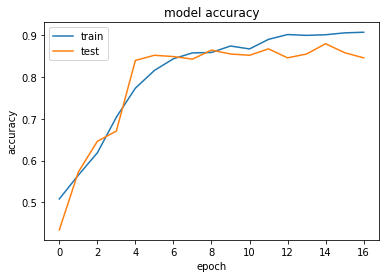

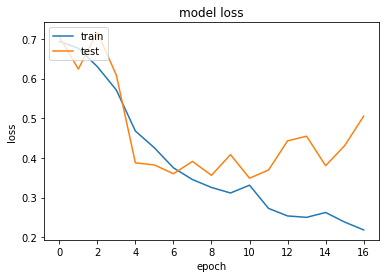

In [79]:
print(history[0].history.keys())
# summarize history for accuracy
plt.plot(history[0].history['accuracy'])
plt.plot(history[0].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model = models.load_model(projet_path+'my_model.h5')

In [ ]:
loss,acc=model.evaluate(test_d)

In [94]:
predictions=modele.predict_classes(test_d)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [95]:
labels = []
for _ ,label in test_ds.as_numpy_iterator():
  labels.append(label)
  
c_matrics = tf.math.confusion_matrix(
    labels, predictions, num_classes=2,
)

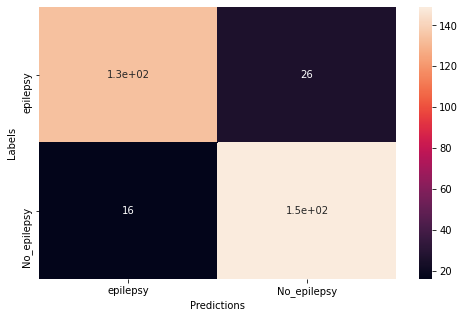

In [97]:
plt.figure(figsize=(8,5))
sns.heatmap(c_matrics,annot=True,xticklabels=["epilepsy","No_epilepsy"],yticklabels=["epilepsy","No_epilepsy"])
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show()

In [98]:
print(classification_report(labels, predictions,digits=7,target_names=["epilepsy","No_epilepsy"]))

              precision    recall  f1-score   support

    epilepsy  0.8933333 0.8375000 0.8645161       160
 No_epilepsy  0.8514286 0.9030303 0.8764706       165

    accuracy                      0.8707692       325
   macro avg  0.8723810 0.8702652 0.8704934       325
weighted avg  0.8720586 0.8707692 0.8705853       325



#Prod test

In [23]:

csv_test_files = preprocessing(projet_path,edf_names[:3])

Extracting EDF parameters from /content/drive/MyDrive/dataset/edfu/no_epilepsy/00002744_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/dataset/edfu/no_epilepsy/00002744_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/dataset/edfu/no_epilepsy/00002744_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2
reste (40000, 19)
/content/drive/MyDrive/dataset/prod/eb70d720-a307-11eb-82f2-0242ac1c0002


In [26]:
test = tf.data.Dataset.from_tensor_slices(get_data_label2(csv_test_files))

0
1
2
3
4
5
6
7
8
9
[0 0 0 0 0 0 0 0 0 0]


In [36]:
prediction(test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'no_epilepsy'